$$
\LaTeX macros
\newcommand{\pba}{{p^b_a}}
\newcommand{\de}{{\dot{e}}}
\newcommand{\dde}{{\ddot{e}}}
\newcommand{\pbd}{{p^b_d}}
\newcommand{\dpba}{{\dot{p}^b_a}}
\newcommand{\ddpba}{{\ddot{p}^b_a}}
\newcommand{\dpbd}{{\dot{p}^b_d}}
\newcommand{\ddpbd}{{\ddot{p}^b_d}}
\newcommand{\pag}{{p^a_g}}
\newcommand{\pav}{{p^a_v}}
\newcommand{\dpag}{{\dot{p}^a_g}}
\newcommand{\pai}{{p^a_i}}
\newcommand{\dpai}{{\dot{p}^a_i}}
\newcommand{\pbg}{{p^b_g}}
\newcommand{\dpbg}{{\dot{p}^b_g}}
\newcommand{\ddpbg}{{\ddot{p}^b_g}}
\newcommand{\pbi}{{p^b_i}}
\newcommand{\dpbi}{{\dot{p}^b_i}}
\newcommand{\ddpbi}{{\ddot{p}^b_i}}
\newcommand{\Rba}{{R^b_a}}
\newcommand{\dRba}{{\dot{R}{}^b_a}}
\newcommand{\ddRba}{{\ddot{R}{}^b_a}}
\newcommand{\Rab}{{R^a_b}}
\newcommand{\omaa}{{\omega^a_a}}
\newcommand{\domaa}{{\dot{\omega}{}^a_a}}
\newcommand{\Somaa}{{S\left(\omega^a_a\right)}}
\newcommand{\dSomaa}{{S\left(\dot{\omega}{}^a_a\right)}}
\newcommand{\Spag}{{S\left(p^a_g\right)}}
\newcommand{\Spai}{{S\left(p^a_i\right)}}
\newcommand{\nuaa}{{\nu^a_a}}
\newcommand{\dnuaa}{{\dot{\nu}{}^a_a}}
\newcommand{\Fb}{{F^b}}
\newcommand{\Fa}{{F^a}}
\newcommand{\Fg}{{F_g}}
\newcommand{\Fv}{{F_v}}
\newcommand{\Ng}{{N_g}}
\newcommand{\Nv}{{N_v}}
\newcommand{\Fe}{{F^{ext}}}
\newcommand{\Na}{{N^a}}
\newcommand{\iM}{{M^{-1}}}
\newcommand{\BM}{\left[\begin{matrix}}
\newcommand{\EBM}{\end{matrix}\right]}
\newcommand{\gamaa}{{\gamma^a_a}}
\newcommand{\dgamaa}{{\dot{\gamma}{}^a_a}}
\newcommand{\vx}{\vec{x}}
\newcommand{\vt}{\vec{\tau}}
\newcommand{\vn}{\vec{\nu}}
\newcommand{\T}{^\top}
\newcommand{\o}[1]{{\overline{#1}}}
\newcommand{\d}[2]{{\frac{\partial #1}{\partial #2}}}
\newcommand{\xpba}{{\,}^x{\!}p^b_a}
\newcommand{\ypba}{{\,}^y{\!}p^b_a}
\newcommand{\As}{{A^{\!*}}}
$$


## Implementacja artykułu "Adaptive sliding-mode attitude control for autonomous underwater vehicles with input nonlinearities"

Link do artykułu:    https://doi.org/10.1016/j.oceaneng.2016.06.041

## Import

In [1]:
import sympy as sp 
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt # ploting results
from scipy.integrate import solve_ivp # solving differential equations
from scipy import linalg # solving are
MAT = np.array
%config IPCompleter.greedy=True

In [2]:
#definicja dekoratora log_results
import functools

def log_results(func):
    @functools.wraps(func)
    def w_dec(*args, **kwargs):
        res = func(*args, **kwargs)
        t_old = -1 if len(w_dec.t) == 0 else w_dec.t[-1]
        t_new = args[0]
        if t_new > t_old:
            w_dec.log.append(res)
            w_dec.t.append(args[0])
        else:
            f = filter(lambda x: x >= t_new, w_dec.t)
            idx = w_dec.t.index(next(f))
            w_dec.log = w_dec.log[0:idx]+[res]
            w_dec.t = w_dec.t[0:idx]+[t_new]
        return res
    w_dec.log = []
    w_dec.t = []
    return w_dec

## Zmienne symboliczne

In [3]:
t = sp.symbols('t') # czas
psi_, tta_, phi_ = sp.symbols('\\psi \\theta \\phi', cls=sp.Function)# kąty Eulera kolejno yaw, pitch, roll
psi, tta, phi = psi_(t), tta_(t), phi_(t)
psi_0, Omy_0 = sp.symbols('\\psi(0) \\omega_y(0)')
x_, y_, z_ = sp.symbols('x y z', cls=sp.Function) # położenie torpedy w układzie globalnym
x, y, z = x_(t), y_(t), z_(t)
Vx_, Vy_, Vz_ = sp.symbols('V_x V_y V_z', cls=sp.Function) # prędkosci liniowe w układzie lokalnym
Vx, Vy, Vz = Vx_(t), Vy_(t), Vz_(t)
dVx_, dVy_, dVz_ = sp.symbols('\dot{V}_x \dot{V}_y \dot{V}_z', cls=sp.Function) # prędkosci liniowe w układzie lokalnym
dVx, dVy, dVz = dVx_(t), dVy_(t), dVz_(t)
Omx_, Omy_, Omz_ = sp.symbols('\\omega_x \\omega_y \\omega_z', cls=sp.Function) # prędkosci kątowe w układzie lokalnym
Omx, Omy, Omz = Omx_(t), Omy_(t), Omz_(t)
dOmx_, dOmy_, dOmz_ = sp.symbols('\dot{\\omega}_x \dot{\\omega}_y \dot{\\omega}_z', cls=sp.Function) # prędkosci kątowe w układzie lokalnym
dOmx, dOmy, dOmz = dOmx_(t), dOmy_(t), dOmz_(t)
V = sp.symbols('V') # prędkość wypadkowa sqrt(Vx^2 + Vy^2 + Vz^2)
xc, yc, zc = sp.symbols('x_c y_c z_c') # współrzędne odległości od środka ciężkości do środka wyporności 
de, dr, dd = sp.symbols('\\delta_e \\delta_r \\delta_d')

beta, alpha = sp.symbols('\\beta \\alpha') # kąt pooślizgu i natarcia
m, rho, L, S, T = sp.symbols('m \\rho L S T') # masa torpedy, gęstość wody, długość i przekrój poprzeczny torpedy, siła ciagu
lam11, lam22, lam33, lam44 = sp.symbols('\\lambda_{11} \\lambda_{22} \\lambda_{33} \\lambda_{44}') # masa dodana
lam26, lam35, lam55, lam66 = sp.symbols('\\lambda_{26} \\lambda_{35} \\lambda_{55} \\lambda_{66}') # masa dodana
Jxx, Jyy, Jzz = sp.symbols('J_{xx} J_{yy} J_{zz}') # dodany moment bezwładności
G, dG, dMxp = sp.symbols('G {\\Delta}G {\\Delta}M_{xp}') # współczynniki
Ca_xs, Ca_y, Cde_y, Cwz_y, Cb_z, Cdr_z, Cwy_z = sp.symbols('C^{\\alpha}_{xS} C^{\\alpha}_{y} C^{\\delta_e}_{y} C^{\\omega_z}_{y} C^{\\beta}_{z} C^{\\delta_r}_{z} C^{\\omega_y}_{z}')
mb_x, mdr_x, mdd_x, mox_x, moy_y, mb_y = sp.symbols('m^{\\beta}_x m^{\\delta_r}_x m^{\\delta_d}_x m^{\\omega_x}_x m^{\\omega_y}_y m^{\\beta}_y ')
mdr_y, mox_y, ma_z, mde_z, moz_z = sp.symbols('m^{\\delta_r}_y m^{\\omega_x}_y m^{\\alpha}_z m^{\\delta_e}_z m^{\\omega_z}_z')
c1, c2, c3 = sp.symbols('c_1 c_2 c_3') # c1 c2 wspł hydrodynamiczne c3 wspł wzm sterowania petli otwartej 
c4, c5, c6 = sp.symbols('c_4 c_5 c_6')
f_, d_ = sp.symbols('f d', cls=sp.Function)
f, d = f_(V,psi,Omy,t), d_(t)
D, h, PHI = sp.symbols('D h \\Phi') # nieliniowa część dynamiki i zaburzenia
s, e, edot, lam = sp.symbols('s e \dot{e} \\lambda') # zmienne sterownika ślizgowego
bhat, hhat, rhohat, Lest, tau, k = sp.symbols('\hat{b} \hat{h} \hat{\\rho} L_{est} \\tau k')#estymaty i wzmocnienia
PSId, PSIdbis, PSIddot = sp.symbols('\\Psi_d \ddot{\\Psi}_d \dot{\\Psi}_d') #wartości kąta zadanego, 2 pochoodna, 1 pochodna
k1, k2, k3 = sp.symbols('k_1 k_2 k_3')# wzmocnienia pochodnych estymat
Phib = sp.symbols('\\Phi_b') #wsp ograniczenia funkcji saturacji 
sig, mu, u = sp.symbols('\\sigma m_u u') #zmienne sterowania z martwą strefą
mr, ml, br, bl = sp.symbols('m_r m_l b_r b_l') #parametry martwej strefy
Omyhat, Omyhatdot, k06, k07 = sp.symbols('\hat{\\omega}_y \dot{\hat{\\omega}}_y k_{06} k_{07}')
Dhat, mihat, ghat = sp.symbols('\hat{D} \hat{\\mu} \hat{g}')
b1hat, L1est = sp.symbols('\hat{b}_1 L_{1est}')
k01, k02, k03, k04, k05 = sp.symbols('k_{01} k_{02} k_{03} k_{04} k_{05}')#wsp wzm prawa adaptacji 
drm = sp.symbols('\\delta_{rm}')#górny poziom nasycenia
kwindup, l, c3b, w, du, w2 = sp.symbols('k^* l \\bar{c}_3 w {\\Delta}u w_{aw}')
b2, L2est, c3h = sp.symbols('\hat{b}_2 L_{2est} \\hat{c}_3')
c1h, c2h, c3h = sp.symbols('\hat{c}_1 \hat{c}_2 \hat{c}_3')
c1h_0, c2h_0, c3h_0, rhoh_0, bh_0, gh_0, mih_0, Omyh_0, Dh_0 = sp.symbols('\\hat{c}_1(0) \\hat{c}_2(0) \\hat{c}_3(0) \\hat{\\rho}(0) \\hat{b}(0) \\hat{g}(0) \\hat{\\mu}(0) \\hat{\\omega}_y(0) \\hat{D}(0)')
muu = sp.symbols('m_u', cls=sp.Function)
drm = sp.symbols('\\delta_{rm}')
l_small = sp.symbols('l')

In [4]:
c2h

\hat{c}_2

Definicja kąta poślizgu $\beta$ i kąta natarcia $\alpha$ - rozdział 2.1 opis przed wzorem (1)

In [5]:
beta_ = sp.atan(Vz/sp.sqrt(Vx**2+Vy**2))
alpha_ = -sp.atan(Vy/Vx)
podstaw = {beta:0.05,alpha:alpha_}
#display(beta_,alpha_)

Opis kinematyki AUV - rozdział 2.1 (1)  $\BM \dot{x}\\\dot{y}\\\dot{z} \EBM$

In [6]:
Rot_ = sp.Matrix([[sp.cos(tta)*sp.cos(psi),sp.sin(psi)*sp.sin(phi)-sp.sin(tta)*sp.cos(psi)*sp.cos(phi),sp.sin(psi)*sp.cos(phi)+sp.sin(tta)*sp.cos(psi)],
                 [sp.sin(phi),sp.cos(tta)*sp.cos(phi),sp.sin(phi)-sp.cos(tta)*sp.sin(phi)],
                 [-sp.cos(tta)*sp.sin(psi),sp.cos(psi)*sp.sin(phi)+sp.sin(tta)*sp.sin(psi)*sp.cos(phi),sp.cos(psi)*sp.cos(phi)-sp.sin(tta)*sp.sin(psi)*sp.sin(phi)]])
V_ = sp.Matrix([[Vx, Vy, Vz]]).T
velState_ = Rot_@V_ # wektor stanu pochodnych położenia
display(Rot_,V_)

Matrix([
[ cos(\psi(t))*cos(\theta(t)), sin(\phi(t))*sin(\psi(t)) - sin(\theta(t))*cos(\phi(t))*cos(\psi(t)),               sin(\psi(t))*cos(\phi(t)) + sin(\theta(t))*cos(\psi(t))],
[                sin(\phi(t)),                                          cos(\phi(t))*cos(\theta(t)),                           -sin(\phi(t))*cos(\theta(t)) + sin(\phi(t))],
[-sin(\psi(t))*cos(\theta(t)), sin(\phi(t))*cos(\psi(t)) + sin(\psi(t))*sin(\theta(t))*cos(\phi(t)), -sin(\phi(t))*sin(\psi(t))*sin(\theta(t)) + cos(\phi(t))*cos(\psi(t))]])

Matrix([
[V_x(t)],
[V_y(t)],
[V_z(t)]])

Opis kinematyki AUV - rozdział 2.1 (2)  $\BM \dot{\psi}\\\dot{\theta}\\\dot{\phi} \EBM$

In [7]:
Rot2_ = sp.Matrix([[0,1/sp.cos(tta)*sp.cos(phi),1/sp.cos(tta)*sp.sin(phi)],
                   [0,sp.sin(phi),sp.cos(phi)],
                   [1,-sp.tan(tta)*sp.cos(phi),sp.tan(tta)*sp.sin(phi)]])
Om_ = sp.Matrix([[Omx,Omy,Omz]]).T
dAngState_ = Rot2_@Om_
display(Rot2_,Om_)

Matrix([
[0,  cos(\phi(t))/cos(\theta(t)), sin(\phi(t))/cos(\theta(t))],
[0,                 sin(\phi(t)),                cos(\phi(t))],
[1, -cos(\phi(t))*tan(\theta(t)), sin(\phi(t))*tan(\theta(t))]])

Matrix([
[\omega_x(t)],
[\omega_y(t)],
[\omega_z(t)]])

Równania dynamiki - rozdział 2.1 (3)

In [8]:
dVx_ = (T-0.5*Ca_xs*rho*V**2*S-dG*sp.sin(tta))/(m + lam11)
dVy_ = (-(m*xc+lam26)*dOmz-m*Vx*Omz+0.5*rho*V**2*S*(Ca_y*alpha+Cde_y*de+Cwz_y*Omz)-dG*sp.cos(tta)*sp.cos(phi))/(m + lam22)
dVz_ = ((m*xc-lam35)*dOmy+m*Vx*Omy+0.5*rho*V**2*S*(Cb_z*beta+Cdr_z+Cwy_z)+dG*sp.cos(tta)*sp.sin(phi))/(m + lam33)
dOmx_ = (m*Vx*(yc*Omx+zc*Omx)+0.5*rho*V**2*S*L*(mb_x*beta+mdr_x*dr+mdd_x*dd+mox_x*Omx+moy_y*Omy)+G*sp.cos(tta)*(yc*sp.sin(phi)+zc*sp.cos(phi))+dMxp)/(Jxx+lam44)
dOmy_ = (-m*Vx*xc*Omy+(m*xc-lam35)*dVz+0.5*rho*V**2*S*L*(mb_y*beta+mdr_y*dr+mox_y*Omx+moy_y*Omy)-G*(xc*sp.cos(tta)*sp.sin(phi)+zc*sp.sin(tta)))/(Jyy+lam55)
dOmz_ = (-m*Vx*xc*Omz-(m*xc+lam26)*dVy+0.5*rho*V**2*S*L*(ma_z*alpha+mde_z*de+moz_z*Omz)+G*(yc*sp.sin(tta)-xc*sp.cos(tta)*sp.cos(phi)))/(Jzz+lam66)
display(dVx_,dVy_,dVz_,dOmx_,dOmy_,dOmz_) 

(-0.5*C^{\alpha}_{xS}*S*V**2*\rho + T - {\Delta}G*sin(\theta(t)))/(\lambda_{11} + m)

(0.5*S*V**2*\rho*(C^{\alpha}_{y}*\alpha + C^{\delta_e}_{y}*\delta_e + C^{\omega_z}_{y}*\omega_z(t)) - m*V_x(t)*\omega_z(t) - {\Delta}G*cos(\phi(t))*cos(\theta(t)) + (-\lambda_{26} - m*x_c)*\dot{\omega}_z(t))/(\lambda_{22} + m)

(0.5*S*V**2*\rho*(C^{\beta}_{z}*\beta + C^{\delta_r}_{z} + C^{\omega_y}_{z}) + m*V_x(t)*\omega_y(t) + {\Delta}G*sin(\phi(t))*cos(\theta(t)) + (-\lambda_{35} + m*x_c)*\dot{\omega}_y(t))/(\lambda_{33} + m)

(G*(y_c*sin(\phi(t)) + z_c*cos(\phi(t)))*cos(\theta(t)) + 0.5*L*S*V**2*\rho*(\beta*m^{\beta}_x + \delta_d*m^{\delta_d}_x + \delta_r*m^{\delta_r}_x + m^{\omega_x}_x*\omega_x(t) + m^{\omega_y}_y*\omega_y(t)) + m*(y_c*\omega_x(t) + z_c*\omega_x(t))*V_x(t) + {\Delta}M_{xp})/(J_{xx} + \lambda_{44})

(-G*(x_c*sin(\phi(t))*cos(\theta(t)) + z_c*sin(\theta(t))) + 0.5*L*S*V**2*\rho*(\beta*m^{\beta}_y + \delta_r*m^{\delta_r}_y + m^{\omega_x}_y*\omega_x(t) + m^{\omega_y}_y*\omega_y(t)) - m*x_c*V_x(t)*\omega_y(t) + (-\lambda_{35} + m*x_c)*\dot{V}_z(t))/(J_{yy} + \lambda_{55})

(G*(-x_c*cos(\phi(t))*cos(\theta(t)) + y_c*sin(\theta(t))) + 0.5*L*S*V**2*\rho*(\alpha*m^{\alpha}_z + \delta_e*m^{\delta_e}_z + m^{\omega_z}_z*\omega_z(t)) - m*x_c*V_x(t)*\omega_z(t) - (\lambda_{26} + m*x_c)*\dot{V}_y(t))/(J_{zz} + \lambda_{66})

Obliczenie prędkości - rozdział 2.1 

In [9]:
V_ = sp.sqrt(Vx**2+Vy**2+Vz**2)
podstaw.update({V:V_})
display(V_)

sqrt(V_x(t)**2 + V_y(t)**2 + V_z(t)**2)

Równania dynamiki i kinematyki kąta odchylenia - rozdział 2.2 (4)

In [10]:
dPsi_ = Omy  
dOMy_ = c1*Omy + c2*beta + c3*dr + f + d 
display(dPsi_, dOMy_)

\omega_y(t)

\beta*c_2 + \delta_r*c_3 + c_1*\omega_y(t) + d(t) + f(V, \psi(t), \omega_y(t), t)

Kompaktowa forma wzoru (4) - rozdział 2.2 (5)

In [11]:
h_ = sp.Matrix([[c1,c2]]).T
PHI_ = sp.Matrix([[Omy,beta]]).T
dOmy2_ = sp.Transpose(h_)@PHI_ + sp.Matrix([[c3*dr]]) + sp.Matrix([[D]])
display(dOmy2_)

Matrix([[D + \beta*c_2 + \delta_r*c_3 + c_1*\omega_y(t)]])

Definicja błędwów śledzenia trajektorii zadanej - rozdział 2.2 (6)

In [12]:
e_ = psi - PSId
edot_ = Omy - PSIddot
podstaw.update({e:e_,edot:edot_})
display(e,edot_)

e

-\dot{\Psi}_d + \omega_y(t)

Sterowanie ślizgowe - rozdział 3 (7)

In [13]:
s_ = edot + lam*e
display(s_)

\dot{e} + \lambda*e

Prawo sterowania - rozdział 3 (13)

In [14]:
znak = sp.sign(s) 
Lest_ = -tau*s - k*znak - hhat*PHI - rhohat*znak + PSIdbis - lam*(Omy - PSIddot)
dr_ = bhat*Lest
podstaw.update({Lest:Lest_})
display(dr_,Lest_)

L_{est}*\hat{b}

-\Phi*\hat{h} + \ddot{\Psi}_d - \hat{\rho}*sign(s) - \lambda*(-\dot{\Psi}_d + \omega_y(t)) - \tau*s - k*sign(s)

Prawo adaptacji - rozdział 3 (14)

In [15]:
h1hatdot_ = k1*Omy*s
h2hatdot_ = k1*beta*s
hhatdot_ = sp.Matrix([[h1hatdot_,h2hatdot_]]).T
bhatdot_ = - k2*Lest*s
rhohatdot_ = k3*sp.Abs(s)
display(hhatdot_,bhatdot_,rhohatdot_)

Matrix([
[k_1*s*\omega_y(t)],
[      \beta*k_1*s]])

-L_{est}*k_2*s

k_3*Abs(s)

Saturacja sygnału - rozdział 3 (19)

In [16]:
sat_sig = sp.Piecewise((-Phib,s<-Phib),(Phib,s>Phib),(1/Phib,True))
display(sat_sig)

Piecewise((-\Phi_b, \Phi_b < -s), (\Phi_b, \Phi_b < s), (1/\Phi_b, True))

Model sterowania z martwą strefą - sygnał sterujący - rozdział 4.1 (20)

In [17]:
dr2_ = mu*u + sig
display(dr2_)

\sigma + m_u*u

In [18]:
mu_sat = sp.Piecewise((mr,u>0),(ml,u<=0)) 
sig_sat = sp.Piecewise((-ml*bl,u<=-bl),(mr*br,u>=br),(muu(u)*u,(u>-bl)&(u<br)))
display(mu_sat,sig_sat)

Piecewise((m_r, u > 0), (m_l, True))

Piecewise((-b_l*m_l, b_l <= -u), (b_r*m_r, b_r <= u), (u*m_u(u), True))

Obserwator zaburzeń - rozdział 4.2 (26)

In [19]:
Dhatdot_ = -k06*(Omyhat-Omy)
Omyhatdot_ = Dhat + mihat*u +ghat + c1h*Omy + c2h*beta - k07*(Omyhat - Omy)
display(Dhatdot_,Omyhatdot_)

-k_{06}*(\hat{\omega}_y - \omega_y(t))

\beta*\hat{c}_2 + \hat{D} + \hat{\mu}*u + \hat{c}_1*\omega_y(t) + \hat{g} - k_{07}*(\hat{\omega}_y - \omega_y(t))

Projekt sterownika dla wejścia z martwą strefą - rozdział 4.3 (27)

In [20]:
u_ = b1hat*L1est
hp = hhat*PHI
L1est1_ = -tau*s - k*sp.sign(s) - hp - ghat - Dhat - rhohat*sp.sign(s) + PSIdbis - lam*(Omy - PSIddot)
hp = c1h*Omy + c2h*beta
L1est_ = -tau*s - k*sp.sign(s) - hp - ghat - Dhat - rhohat*sp.sign(s) + PSIdbis - lam*(Omy - PSIddot)
podstaw.update({u:u_,L1est:L1est_})
display(u_,L1est1_)

L_{1est}*\hat{b}_1

-\Phi*\hat{h} + \ddot{\Psi}_d - \hat{D} - \hat{\rho}*sign(s) - \hat{g} - \lambda*(-\dot{\Psi}_d + \omega_y(t)) - \tau*s - k*sign(s)

Prawo adaptacji - rozdział 4.3 (30)

In [21]:
h12hatdot_ = k01*Omy*s - k01*(Omyhat-Omy)*Omy
h22hatdot_ = k01*beta*s - k01*(Omyhat-Omy)*beta
h1hatdot_ = sp.Matrix([[h12hatdot_,h22hatdot_]]).T
b1hatdot_ = -k02*L1est*s
rho1hatdot_ = k03*sp.Abs(s)
ghatdot_ = k04*s - k04*(Omyhat-Omy)
mihatdot_ = -k05*(Omyhat-Omy)*u
display(h1hatdot_,b1hatdot_,rho1hatdot_,ghatdot_,mihatdot_)

Matrix([
[k_{01}*s*\omega_y(t) - k_{01}*(\hat{\omega}_y - \omega_y(t))*\omega_y(t)],
[            \beta*k_{01}*s - \beta*k_{01}*(\hat{\omega}_y - \omega_y(t))]])

-L_{1est}*k_{02}*s

k_{03}*Abs(s)

k_{04}*s - k_{04}*(\hat{\omega}_y - \omega_y(t))

-k_{05}*u*(\hat{\omega}_y - \omega_y(t))

Sterowanie z nasyceniem - rozdział 4.4 
Charakterystyka saturacji (35)

In [22]:
drm_ = 12*np.pi/180  #kąt nasycenia
drm_sat = sp.Piecewise((drm,u>drm),(-drm,u<-drm),(u,(u<=drm) & (u>=-drm)))
display(drm_sat)

Piecewise((\delta_{rm}, \delta_{rm} < u), (-\delta_{rm}, \delta_{rm} < -u), (u, True))

Kompensator anti-windup - rozdział 4.4 (36)

In [23]:
du_ = dr-u
#w_ = -kwindup*w - w*(sp.Abs(c3b*s*du)+0.5*du**2)/(sp.Abs(w)**2)+du 
wf_ = sp.Piecewise((-kwindup*w - w*(sp.Abs(c3b*s*du)+0.5*du**2)/(sp.Abs(w)**2)+du,sp.Abs(w)>=l_small),(0,True))
podstaw.update({du:du_,w2:wf_})
display(wf_)

Piecewise((-k^**w - w*(0.5*{\Delta}u**2 + Abs(\bar{c}_3*s*{\Delta}u))/Abs(w)**2 + {\Delta}u, l <= Abs(w)), (0, True))

Prawo sterowania - rozdział 4.4 (37)

In [24]:
u2_ = b2*L2est
b2_ = 1/c3
L2est_ = -tau*(s - w2) - k*sp.sign(s) - hhat*PHI - ghat - Dhat - rhohat*znak + PSIdbis - lam*(Omy - PSIddot)
podstaw.update({b2:b2_,L2est:L2est_})
#display(u2_,L2est_)

Obserwator zakłóceń - rozdział 4.4 (38)

In [25]:
D2hatdot_ = -k06*(Omyhat-Omy)
Omy2hatdot_ = Dhat + c3h*dr + hhat*PHI - k07*(Omyhat - Omy)
#display(D2hatdot_,Omy2hatdot_)

Prawo adaptacji - rozdział 4.4 (39)

In [26]:
h31hatdot_ = k01*Omy*s - k01*Omy*(Omyhat - Omy) 
h32hatdot_ = k01*beta*s - k01*beta*(Omyhat - Omy)
h3_ = sp.Matrix([[h31hatdot_,h32hatdot_]]).T
b2dothat_ = -k02*L2est*s
rho2hatdot_ = k03*sp.Abs(s)
c3hatdot_ = -(Omyhat - Omy)*dr    
#display(h3_,b2dothat_,rho2hatdot_,c3hatdot_)   

Zewnętrzne zaburzenie - rozdział 5

In [27]:
dis_ = 0.55*sp.sin(0.01*t) + 0.33*sp.sin(0.1*t) + 0.25*sp.cos(0.02*t) + 0.3*sp.sin(0.1*t)*sp.cos(0.2*t)
#display(dis_)

Wymuszenie - rozdział 5

In [28]:
Trec = 20 # okres sygnału prostokątnego
Amp = 28.7 # amplituda sygnału prostokątnego
flt = 0.02 # moc filtra z zakresu 0 - 1
def Rectangle(t_):
    tmp = t_%Trec
    filt = flt/4
    # pierwszy cykl
    if t_ <= (filt*Trec): return 0
    # pozostałe
    if tmp >= (filt*Trec) and tmp <= 0.5*Trec-(filt*Trec):
        return 0
    if tmp > 0.5*Trec-(filt*Trec) and tmp < 0.5*Trec+(filt*Trec):
        tsin = (((tmp-(0.5*Trec-filt*Trec))/(2*filt*Trec))*np.pi)-np.pi/2
        return np.sin(tsin)*Amp/2+Amp/2
    if tmp >= 0.5*Trec+(filt*Trec) and tmp <= Trec-(filt*Trec):
        return Amp
    if tmp > Trec-(filt*Trec) or tmp < (filt*Trec):
        tsin_cont = tmp-(Trec-filt*Trec) 
    if tmp-(Trec-filt*Trec)+Trec :
        tsin = (tsin_cont/(2*filt*Trec))*np.pi
        return np.sin(tsin+np.pi/2)*Amp/2+Amp/2

## Wartości zmiennych symbolicznych

In [29]:
params ={c1:-4.695,c2:10.735,c3:1.8207,c4:0.2623,c5:-1.274,c6:-0.102}#nominalne parametry modelu
params.update({psi_0:10*np.pi/180,Omy_0:3*np.pi/180})#wartości początkowe
params.update({c1h_0:-1, c2h_0:2, c3h_0:0, rhoh_0:0.5, bh_0:0, gh_0:0, mih_0:0, Omyh_0:0, Dh_0:0.6})#wart. pocz. estymat
params.update({mr:0.3, ml:0.12, br:1, bl:1.3})#wart. saturacji i martwej strefy
params.update({k:20,lam:1,k1:60, k2:60, k3:60, k01:60, k02:60, k03:60, k04:60, k05:60, k06:1, k07:1})#wzmocnienie poch. estymat
params.update({k:0.02,kwindup:20,tau:20,lam:1,c3b:1.8207,l_small:0.5})
params.update({drm:12*np.pi/180})
params.update({T:450,Jyy:23.8,Jzz:23.8,Jxx:0.56,dG:10,m:1,L:2.015,S:0.0628,rho:1,G:1})
params.update({Ca_xs:-0.45,Ca_y:1.98,Cde_y:4.62,Cwz_y:0.67,Cb_z:-1.92,Cdr_z:-5.89,Cwy_z:-0.67,mb_x:-0.01})
params.update({mdr_x:-0.04,mdd_x:-0.04,mb_y:-0.01,mdr_y:-0.04,ma_z:0.31,mde_z:-0.04,mox_x:0.01,moy_y:0.01,mox_y:0.01})
params.update({lam11:1,lam22:1,lam33:1,lam44:1,lam55:1,lam66:1,lam26:0.01,lam35:0.01,moz_z:0.01})
params.update({xc:0.1,yc:0.1,zc:0.1,beta:0.02,dMxp:0})

Funkcje numeryczne

In [30]:
dr2_num = sp.lambdify((sig,u,mu),dr2_.subs(params))
s_num = sp.lambdify((Omy,psi,PSId,PSIddot),s_.subs(podstaw).subs(params))
u_num = sp.lambdify((b1hat,PSIdbis,PSIddot,Dhat,rhohat,s,c1h,Omy,c2h,ghat),u.subs(podstaw).subs(params).subs(podstaw).subs(params).subs(podstaw).subs(params))
Dhatdot_num = sp.lambdify((Omy,Omyhat),Dhatdot_.subs(params))
Omyhatdot_num = sp.lambdify((Dhat,mihat,b1hat,PSIdbis,PSIddot,rhohat,s,c1h,c2h,Omy,Omyhat,ghat),Omyhatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
h12hatdot_num = sp.lambdify((s,Omy,Omyhat),h12hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
h22hatdot_num = sp.lambdify((s,Omy,Omyhat),h22hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
b1hatdot_num = sp.lambdify((s,PSIddot,PSIdbis,Dhat,rhohat,c1h,c2h,Omy,ghat),b1hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
rho1hatdot_num = sp.lambdify((s),rho1hatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))#
ghatdot_num = sp.lambdify((s,Omy,Omyhat),ghatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))#
midothat_num = sp.lambdify((s,b1hat,Omy,Omyhat,PSIddot,PSIdbis,Dhat,rhohat,c1h,c2h,ghat),mihatdot_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
#
dPsi_num = sp.lambdify((Omy),dPsi_)
dOmy2_num = sp.lambdify((D,dr,Omy),dOmy2_.subs(podstaw).subs(podstaw).subs(podstaw).subs(params))
#
dis_num = sp.lambdify((t),dis_)
sat_sig_num = sp.lambdify((Phib,s),sat_sig.subs(params))
mu_sat_num = sp.lambdify((u),mu_sat.subs(params))
sig_sat_num = sp.lambdify((u,muu(u)),sig_sat.subs(params))
drm_sat_num = sp.lambdify((u),drm_sat.subs(params))
wf_sat_num = sp.lambdify((dr,u,s,w),wf_.subs(podstaw).subs(params))
alpha_num = sp.lambdify((Vx,Vy),alpha_)
# dynamika
dVx_num = sp.lambdify((V,tta),dVx_.subs(params))
dVy_num = sp.lambdify((de,dOmz,Vx,Omz,V,tta,phi,alpha),dVy_.subs(params))
dVz_num = sp.lambdify((dOmy,Vx,Omy,V,tta,phi),dVz_.subs(params))
dOmx_num = sp.lambdify((Vx,Omx,V,dr,dd,Omy,tta,phi),dOmx_.subs(params))
dOmy_num = sp.lambdify((Vx,Omy,dVz,V,dr,Omx,Omy,tta,phi),dOmy_.subs(params))
dOmz_num = sp.lambdify((Vx,Omz,dVy,V,alpha,de,Omz,tta,phi),dOmz_.subs(params))
V_num = sp.lambdify((Vx,Vy,Vz),V_)
# kinematyka
velState_num = sp.lambdify((tta,phi,psi,Vx,Vy,Vz),velState_)
dAngState_num = sp.lambdify((tta,phi,psi,Omx,Omy,Omz),dAngState_)


# Definicja funkcji dekoratora

In [31]:
@log_results
def control(t,b1i,Di,rhoi,si,c1hi,Omyi,c2hi,gi):
    return u_num(b1i,0,0,Di,rhoi,si,c1hi,Omyi,c2hi,gi)
@log_results
def control_dr(t,sig,u,mu):
    return dr2_num(sig,u,mu)
@log_results
def control_s(t,Omyi,psii,PSId,PSIddot):
    return s_num(Omyi,psii,PSId,PSIddot)

# Definicja funkcji symulacji 

In [32]:
def Torpeda(t_, x0_array):
    x0 = MAT([x0_array]).T
    #------------- wartości początkowe
    psii = dOmyi = MAT(x0[0][0])
    Omyi = MAT(x0[1][0])
    
    Omyhati = MAT(x0[2][0])
    c1hi = MAT(x0[3][0])
    c2hi = MAT(x0[4][0])
    rhoi = MAT(x0[5][0])
    gi = MAT(x0[6][0])
    Di = MAT(x0[7][0])
    b1i = MAT(x0[8][0])
    mii = MAT(x0[9][0])
    #------------- wartości początkowe
    alphai = alpha_num(1,0.1)
    #wyswietlanie aktualnego postepu symulacji
    print(t_,end="\r")
    
    #estymaty
    PSId =  Rectangle(t_)
    PSIddot = 0
    #si = s_num(Omyi,psii,PSId,PSIddot)
    si = control_s(t_,Omyi,psii,PSId,PSIddot)
    dc1h = h12hatdot_num(si,Omyi,Omyhati)
    dc2h = h22hatdot_num(si,Omyi,Omyhati)
    drho = rho1hatdot_num(si)
    dg = ghatdot_num(si,Omyi,Omyhati)
    dD = Dhatdot_num(Omyi,Omyhati)
    db1 = b1hatdot_num(si,PSIddot,0,Di,rhoi,c1hi,c2hi,Omyi,gi)
    dmi = midothat_num(si,b1i,Omyi,Omyhati,PSIddot,0,Di,rhoi,c1hi,c2hi,gi)
    dOmyhat = Omyhatdot_num(Di,mii,b1i,0,0,rhoi,si,c1hi,c2hi,Omyi,Omyhati,gi)
    
    #- sterowanie 
    u = u_num(b1i,0,0,Di,rhoi,si,c1hi,Omyi,c2hi,gi)
    #u = control(t_,b1i,Di,rhoi,si,c1hi,Omyi,c2hi,gi)
    mu = mu_sat_num(u)
    sig = sig_sat_num(u,mu)
    #dri = dr2_num(sig,u,mu)
    dri = control_dr(t_,sig,u,mu)
    #część dynamiki z której korzystamy
    dOmyi = dPsi_num(Omyi)
    ddOmyi = dOmy2_num(Di,dri,Omyi)
    #- przygotowanie wyników
    d1 = MAT([dOmyi.item(),ddOmyi.item()])
    d2 = MAT([dOmyhat,dc1h,dc2h,drho,dg,dD,db1,dmi])
    # Zbieranie wyników
    dxi = np.concatenate((np.asarray(d1.flat),np.asarray(d2.flat)))
    return np.ndarray.tolist(dxi)

## Przygotowanie symulacji

In [33]:
xi0_array = [0,0, 0,-1,2,0.5,0,0.6,0,0]#wartości początkowe zmiennych
time_sym =42 # Czas trwania symulacji
sim = solve_ivp(Torpeda, [0, time_sym], xi0_array,atol=0.01)
t = sim.t+0
Omyp,dOmyp,Omyhat,c1h,c2h,rho,g,D,b1,mi  = sim.y # return xi  # 

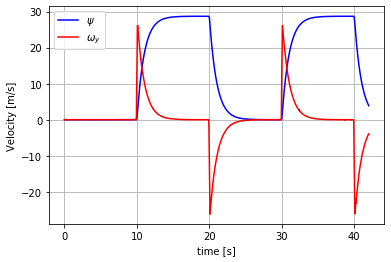

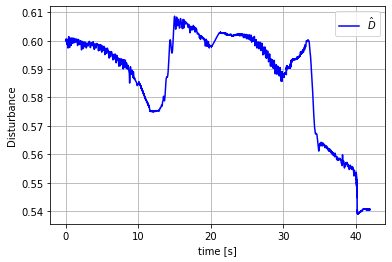

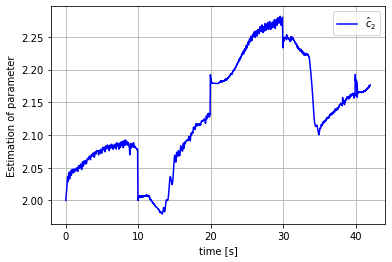

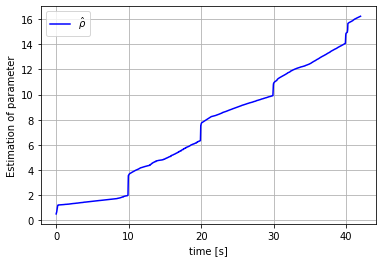

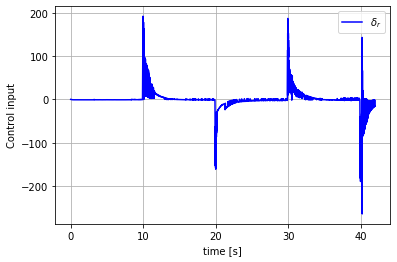

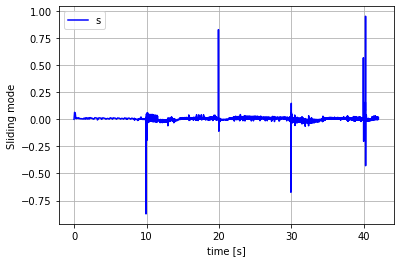

In [35]:
plt.figure()
plt.plot(t, Omyp, 'b', label='$\\psi$')
plt.plot(t, dOmyp, 'r', label='$\\omega_y$')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Velocity [m/s]')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, D, 'b', label='$\hat{D}$')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Disturbance')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, c2h, 'b', label='$\hat{c}_2$')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Estimation of parameter')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(t, rho, 'b', label='$\hat{\\rho}$')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Estimation of parameter')
plt.grid(True)
plt.show()

control_sig_dr = [control_dr.log[control_dr.t.index(time)] for time in t]
plt.figure()
plt.plot(t,control_sig_dr, 'b', label='$\\delta_r$')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Control input')
plt.grid(True)
plt.show()

control_sig_s = [control_s.log[control_s.t.index(time)] for time in t]
plt.figure()
plt.plot(t,control_sig_s, 'b', label='s')
plt.legend(loc = 'best')
plt.xlabel('time [s]')
plt.ylabel('Sliding mode')
plt.grid(True)
plt.show()